## Kindly click on the links to get information about the dataset used for this project

https://zindi.africa/competitions/ghana-crop-disease-detection-challenge/data

https://www.kaggle.com/datasets/ohagwucollinspatrick/ghana-crop-disease 

# Importing important Packages and Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

## Importing other useful packages and libraries 
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import PIL
from PIL import Image

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

# Know the data Directories

## Loading the dataset

In [2]:
## Loading the data set
train_df = pd.read_csv("Train.csv")
# test set
test_df = pd.read_csv("Test.csv")
# The whole dataset
sample_submission = pd.read_csv("SampleSubmission.csv")

print(train_df.head(3))  # Show first few rows
print(train_df.info())  # Check data structure
print(sample_submission.head(4))
print(sample_submission.info())

        Image_ID  confidence                  class        ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot  194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot  149.632401  256.768914   
2  id_11543h.jpg         1.0  Pepper_Bacterial_Spot  234.046875  327.138158   

         ymax        xmax  
0  208.107730  341.967928  
1  162.910362  266.195724  
2  252.712993  338.876645  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41029 entries, 0 to 41028
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Image_ID    41029 non-null  object 
 1   confidence  41029 non-null  float64
 2   class       41029 non-null  object 
 3   ymin        41029 non-null  float64
 4   xmin        41029 non-null  float64
 5   ymax        41029 non-null  float64
 6   xmax        41029 non-null  float64
dtypes: float64(5), object(2)
memory usage: 2.2+ MB
None
        Image_ID                     

In [3]:
# Check unique disease classes
print("Number of Unique Diseases:", train_df['class'].nunique())
print(train_df['class'].value_counts().head(13))

Number of Unique Diseases: 23
class
Corn_Cercospora_Leaf_Spot    6538
Tomato_Septoria              6483
Tomato_Late_Blight           3918
Corn_Streak                  3180
Tomato_Healthy               2872
Pepper_Septoria              2295
Pepper_Leaf_Mosaic           2113
Tomato_Early_Blight          1946
Pepper_Bacterial_Spot        1943
Corn_Common_Rust             1682
Corn_Healthy                 1571
Pepper_Leaf_Curl             1530
Tomato_Fusarium               882
Name: count, dtype: int64


# Data Preprocessing 
1. Create new variable, "image_path" to both the train and test data. This includes the path to our image data.
2. Encode the class varible from string to integer named 'label' 

In [4]:
# Define image directory
IMAGE_DIR = "images/"

# Add full image path column for the training data
train_df["image_path"] = IMAGE_DIR + train_df["Image_ID"]

# Add full image path column for the test data
test_df["image_path"] = IMAGE_DIR + test_df["Image_ID"]

# Encode class labels into numerical values for the training data
train_df['label'] = train_df['class'].astype('category').cat.codes

# Check first few rows
print("train_set\n ",train_df.head(2))
print("test_set\n ",test_df.head(2))

train_set
          Image_ID  confidence                  class        ymin        xmin  \
0  id_11543h.jpg         1.0  Pepper_Bacterial_Spot  194.649671  328.803454   
1  id_11543h.jpg         1.0  Pepper_Bacterial_Spot  149.632401  256.768914   

         ymax        xmax            image_path  label  
0  208.107730  341.967928  images/id_11543h.jpg      5  
1  162.910362  266.195724  images/id_11543h.jpg      5  
test_set
          Image_ID  confidence  class  ymin  xmin  ymax  xmax  \
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN   

             image_path  
0  images/id_128pxx.jpg  
1  images/id_12jbci.jpg  


## Image Visualization

Visualise the first few data of the image dataset using the PIL library

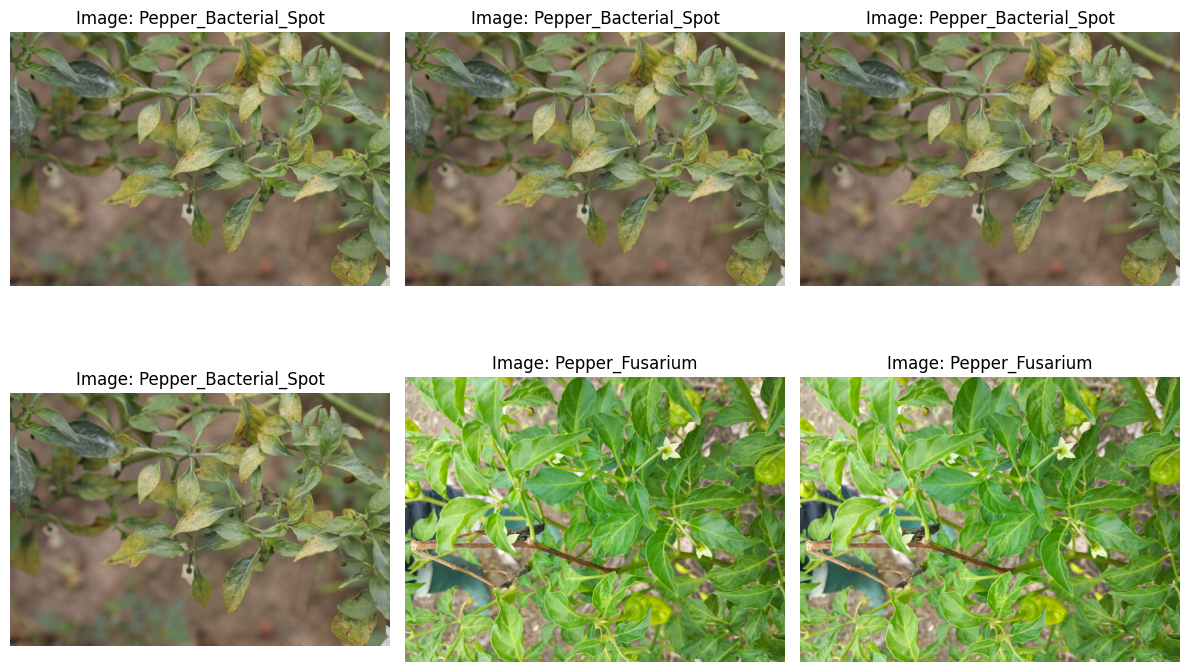

In [5]:
# Create a 2-row, 3-column plot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Adjusted figsize

# Loop through the first 6 images
for i in range(6):
    img_path = train_df["image_path"].iloc[i]  # Correct way to access paths
    img = Image.open(img_path)  # Open the image
    
    row, col = divmod(i, 3)  # Convert index to (row, col) for subplot indexing
    axes[row, col].imshow(img)  # Correct indexing for 2D array
    axes[row, col].axis("off")  # Hide axes
    axes[row, col].set_title(f"Image: {train_df['class'].iloc[i]}")  # add title


plt.tight_layout()  # Adjust layout
plt.show()



In [6]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  ## 20% of training data for validation
)

# Using train_datagen for both training & validation splits
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, 
    x_col='image_path',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',  
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df, 
    x_col='image_path',
    y_col='class',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  # 
    shuffle=False
)


Found 32818 validated image filenames belonging to 23 classes.


C:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 7 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


Found 8204 validated image filenames belonging to 23 classes.


C:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 7 invalid image filename(s) in x_col="image_path". These filename(s) will be ignored.
  warnings.warn(


# Building the CNN

step 1(Conv2D): The activation map (feature map) is created through extracting the needed feature using a 3by3 matrix called feature dector from the input image data. The goal is to extract features from the input image and ensures easy feature detector.

step 2 (Pooling):Using the maxpooling technique of a 2 by 2 matrix, we etract and preserve the most important feature. This also helped in reducing spatial dimensions and, preventing overfitting.

step 3 (Flatten): Restructuring into an input layer of an ANN structure.

step 4: The full convolutional neural network 
step 5: The output layer using softmax activation function.

In [7]:

model = Sequential([
    ## Initializing a three convolutional layers (Step 1 and 2)
    #1st convolutional layer (Input layer)
    Input(shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'), 
    # Conv2D(input image(16by16matrix), feature detector( 3by3 matrix), and activation function ('relu')
    MaxPooling2D(2, 2),# 2by2 Matrix

    #2nd convolutional layer
    Conv2D(64, (3, 3), activation='relu'),
    # Conv2D(input image(32by32matrix), feature detector( 3by3 matrix), and activation function ('relu')
    MaxPooling2D(2, 2),

    # 3rd convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    # Conv2D(input image(64by64matrix), feature detector( 3by3 matrix), and activation function ('relu')
    MaxPooling2D(2, 2),

    # step 3: Flatten
    Flatten(),
    
    #Step 4: Full Connection
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    ## Output layer with unique disease classes
    Dense(train_df['label'].nunique(), activation='softmax') 
])


## Compiling the CNN

In [8]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,831,319 (18.43 MB)

 Trainable params: 4,831,319 (18.43 MB)

 Non-trainable params: 0 (0.00 B)

## Train the CNN model

In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    verbose=1,
)

C:\ProgramData\anaconda3\envs\tf\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3703s 4s/step - accuracy: 0.2656 - loss: 2.4823 - val_accuracy: 0.4088 - val_loss: 1.8112
Epoch 2/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3590s 3s/step - accuracy: 0.3912 - loss: 1.9323 - val_accuracy: 0.4608 - val_loss: 1.6428
Epoch 3/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3628s 4s/step - accuracy: 0.4349 - loss: 1.7463 - val_accuracy: 0.4943 - val_loss: 1.4868
Epoch 4/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3585s 3s/step - accuracy: 0.4623 - loss: 1.6391 - val_accuracy: 0.5261 - val_loss: 1.4446
Epoch 5/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3570s 3s/step - accuracy: 0.4858 - loss: 1.5444 - val_accuracy: 0.5350 - val_loss: 1.3917
Epoch 6/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3568s 3s/step - accuracy: 0.5014 - loss: 1.4837 - val_accuracy: 0.5659 - val_loss: 1.2995
Epoch 7/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3555s 3s/step - accuracy: 0.5148 - loss: 1.4154 - val_accuracy: 0.5575 - val_loss: 1.2592
Epoch 8/10
1026/1026 ━━━━━━━━━━━━━━━━━━━━ 3633s 4s/step - accuracy: 0.5242 -

# Model Evaluation Performance

## Model Accuracy

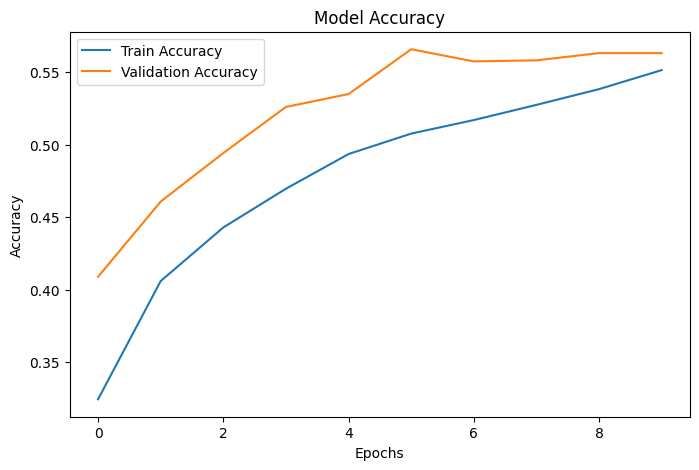

In [10]:
plt.figure(figsize=(8, 5))

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.show()


### Interpretation of Accuracy Plot

The graph shows the relationship between training iterations (epochs) and accuracy during the CNN training process for Ghana crop disease detection. It was observed that both training and validation accuracy increase as the model learns. Around the 6th epoch, an early sign of overfitting appears, as the validation accuracy plateaus slightly while the training accuracy continues to rise. However, overfitting seems to be controlled, and the model generalizes well, as indicated by the relatively small gap between training and validation accuracy.

## Loss Function plot

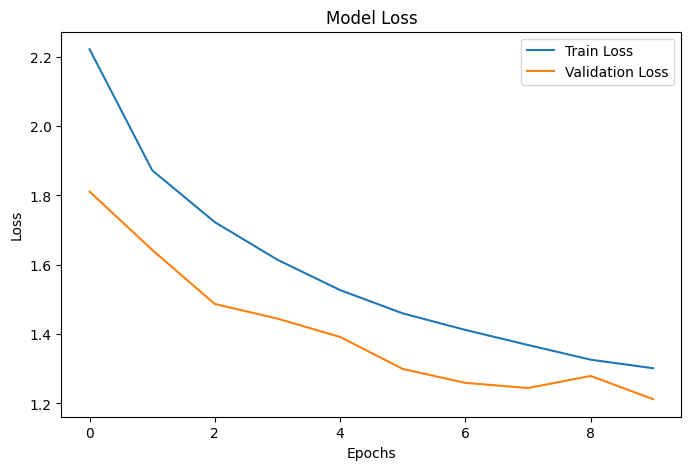

In [11]:
# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

### Interpretation of Loss Plot

The graph shows the relationship between training iterations (epochs) and the model's loss (the difference between predictions and actual values) during the CNN training process for Ghana crop disease detection. A downward trend is observed in both training and validation loss, indicating improved model performance and controlled overfitting.

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df, 
    x_col='image_path',
    target_size=(150, 150),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

# Predict
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

print("Predictions shape:", predictions.shape)



Found 2101 validated image filenames.
66/66 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step
Predictions shape: (2101, 23)


In [13]:
# Convert predictions to labels
label_map = dict((v, k) for k, v in train_generator.class_indices.items())
test_df['Predicted_Label'] = [label_map[i] for i in predicted_classes]

# Save submission
test_df[['Image_ID', 'Predicted_Label']].to_csv("submission.csv", index=False)
print("Submission file saved!")
print(test_df.head(2))

Submission file saved!
        Image_ID  confidence  class  ymin  xmin  ymax  xmax  \
0  id_128pxx.jpg         NaN    NaN   NaN   NaN   NaN   NaN   
1  id_12jbci.jpg         NaN    NaN   NaN   NaN   NaN   NaN   

             image_path  Predicted_Label  
0  images/id_128pxx.jpg  Tomato_Septoria  
1  images/id_12jbci.jpg      Corn_Streak  


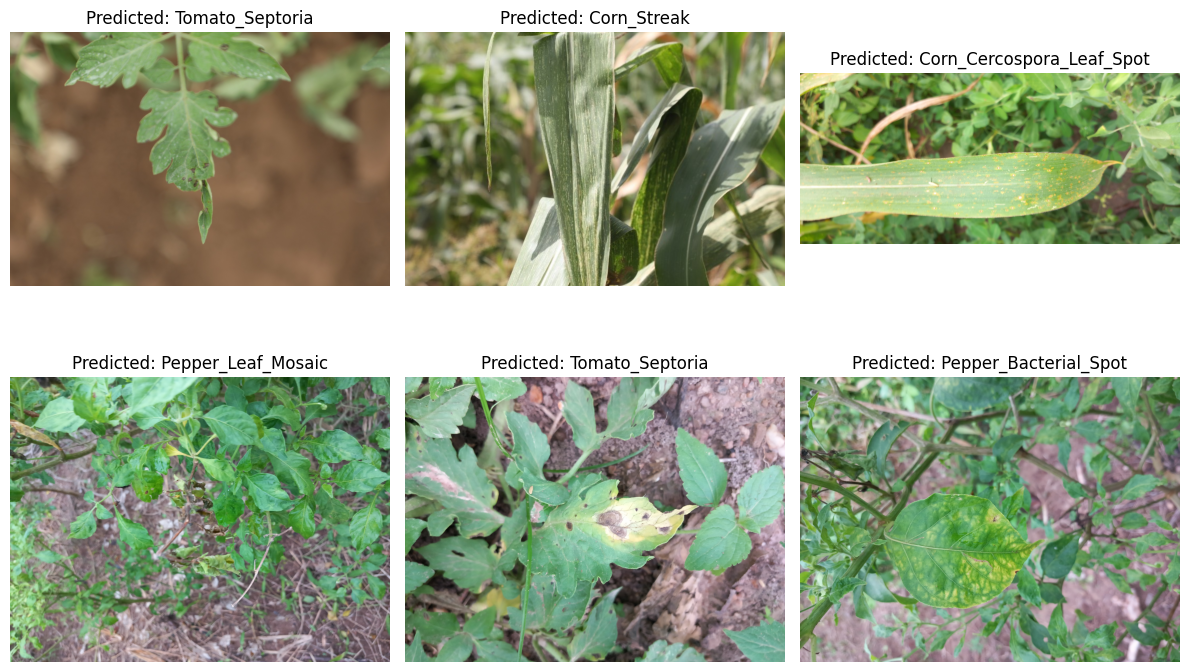

In [14]:
# Create a 2-row, 3-column plot
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # Adjusted figsize

# Loop through the first 6 images
for i in range(6):
    img_path = test_df["image_path"].iloc[i]  # Correct way to access paths
    img = Image.open(img_path)  # Open the image
    
    row, col = divmod(i, 3)  # Convert index to (row, col) for subplot indexing
    axes[row, col].imshow(img)  # Correct indexing for 2D array
    axes[row, col].axis("off")  # Hide axes
    axes[row, col].set_title(f"Predicted: {test_df['Predicted_Label'].iloc[i]}")  # Add title

plt.tight_layout()  # Adjust layout
plt.show()
